# <font color='red'>prepare_dataset.ipynb</font>
The below code cells prepare the given financial dataset to the desired ordinal encoded format for being used by main.ipynb for computing the credit score. A few new attributes are also added into the dataset, the value of which are computed as a combination of one or more pre-existing attributes.

In [1]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data_fs.csv")
df = data.copy() #generating a copy of the actual dataset. The subsequent steps will use this copy of data

In [3]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


### PLOTTING THE DISTRIBUTION OF CREDIT AMOUNT PAID PER MONTH
As can be observed from the plot below, most of the amount paid per month is under the value of 500. However, since a small number of outliers are observed in the below plot, it becomes necessary for the score computation heuristic to appropriately scale the data in order to avoid any biased results.

<font color='red'> Uncomment to display the plots. Commented to avoid the plots to display in main.ipynb</font>

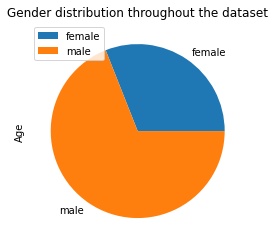

In [3]:
'''temp = pd.DataFrame(df.groupby('Sex')['Age'].count())
temp['Sex'] = temp.index
ax = plt.gca()
temp.plot(kind='pie',x='Sex',y='Age',ax=ax,title='Gender distribution throughout the dataset')
plt.show()'''

In [4]:
purpose = data.Purpose.unique()

### COMPUTING ORDINAL ENCODED LABELS
The original labels to a corresponsing numeric values based on their sequence of preference. For instance: A savings acount value of 'quite rich' will be much more preferable than 'little savings acount value. Thus, the label 'quite rich' is replaced with a larger number ( 4 in this case ) than 'little' ( 1 in this case ).

In [5]:
housing = {'rent':1 , 'free':2, 'own':3}  #these values are idenfitified using data.Housing.unique()

sex = {'female':1, 'male':2}  #these values are idenfitified using data.Sex.unique()

saving = {'None':-1,'little':1,'moderate':2,'rich':3,'quite rich':4}  #these values are idenfitified using data['Saving accounts'].unique()

checking = {'None':-1,'little':1,'moderate':2,'rich':3}   #these values are idenfitified using data['Checking account'].unique()

### ASSIGNING AGE VALUES TO THEIR RESPECTIVE BINS
Each age value is broadly classified into one of the 4 possible age groups:<br>
'1' for age in range [ AGE_MIN , 25 )<br>
'2' for age in range [ 25 , 40 )<br>
'3' for age in range [ 40 , 55 )<br>
'4' for age in range [ 55, AGE_MAX ]<br>

In [6]:
# computing the maximum and minimum age values in the given dataset.

age_min = df['Age'].min()
age_max = df['Age'].max()

#creating age groups of the below given range
breakpoints = [age_min-1,25,40,55,age_max+1]

# age group labels
age_groups = ['1','2','3','4']

#creating a new attribute with value as the age group label of the given age
df['age_group'] = pd.cut(df['Age'], bins=breakpoints, labels=age_groups, right=False)

### COMPUTING AVERAGE AMOUNT PAID PER MONTH BY EACH PERSON
This value is computed as a ratio of the credit amount and the corresponding duration for paying the same

In [7]:
df['amount_per_month'] = df['Credit amount'] / df['Duration'] #the higher the better

### DIVIDING DATA INTO 4 GROUPS BASED ON THE PRESENCE/ ABSENCE OF SAVINGS ACCOUNT AND CHECKING ACCOUNT RESPECTIVELY
This condition only checks whether a given person has a savings account and/or a chceking account. Based on this, the dataset is divided into 4 disjoint subsets, with highest preference for the subset with both savings account and checking account. The least preference is for the subset with no savings account and no checking acount.

In [8]:
p1 = (df[ ~df['Saving accounts'].isna() &  ~df['Checking account'].isna()]) #both savings and checking present
p2 = (df[ ~df['Saving accounts'].isna() &  df['Checking account'].isna()]) #checking account absent
p3 = (df[ df['Saving accounts'].isna() &  ~df['Checking account'].isna()]) #savings account absent
p4 = (df[ df['Saving accounts'].isna() &  df['Checking account'].isna()]) #both the accounts absent

p1['plane']=1  #highest priority
p2['plane']=2
p3['plane']=3
p4['plane']=4  #lowest priority

df = pd.concat([p1,p2,p3,p4]).reset_index(drop=True)

df['Saving accounts'] = df['Saving accounts'].fillna('None') #replacing NaN values with 'None' to avoid
#ambiguities in downstream tasks

df['Checking account'] = df['Checking account'].fillna('None') #replacing NaN values with 'None' to avoid
#ambiguities in downstream tasks

### PRIORITIZING JOB LABELS
Since there is no such explicit information of job labels, their relative importance is computed by observing the average credit amount per month paid per month. This value is higher for job labels '3' and '0' and lower for '1' and '2'. Thus jobs '1' and '2' will have lesser priority than jobs '0' and '3' while computing credit score.

In [9]:
job = pd.DataFrame(df.groupby('Job')['amount_per_month'].mean())
job = {1:1,2:1,3:2,0:2}

### REPLACING LABELS WITH THEIR CORRESPONDING ORDINAL ENCODED LABELS

In [10]:
for i in range(len(df)):
    #print(df.loc[i,'Sex'])
    df.loc[i,'Sex'] = sex[df.loc[i,'Sex']]
    df.loc[i,'Housing'] = housing[df.loc[i,'Housing']]
    df.loc[i,'Saving accounts'] = saving[df.loc[i,'Saving accounts']]
    df.loc[i,'Checking account'] = checking[df.loc[i,'Checking account']]

In [11]:
df.drop(columns=['Unnamed: 0'],inplace=True) #removing non-required columns

### VISUALIZATION OF THE DATASET FOR FEATURE INTERPRETATION
<font color='red'> Uncomment to display the plots. Commented to avoid the plots to display in main.ipynb</font>

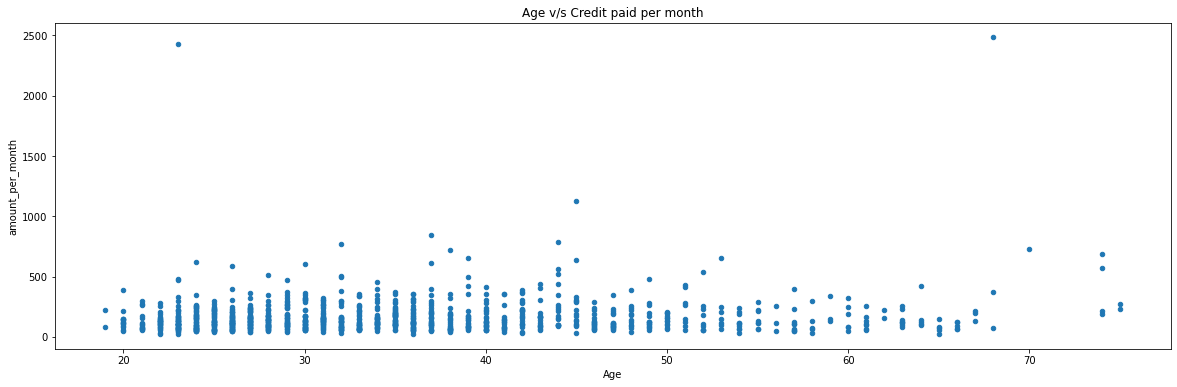

In [12]:
'''ax = plt.gca()
df.plot(kind='scatter',x='Age',y='amount_per_month',ax=ax,title='Age v/s Credit paid per month',figsize=(20,6))
plt.show()'''

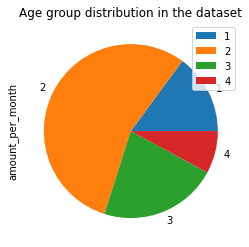

In [13]:
'''temp = pd.DataFrame(df.groupby('age_group')['amount_per_month'].count())
temp['age_group'] = temp.index
ax = plt.gca()
temp.plot(kind='pie',x='age_group',y='amount_per_month',ax=ax,title='Age group distribution in the dataset')
plt.show()'''

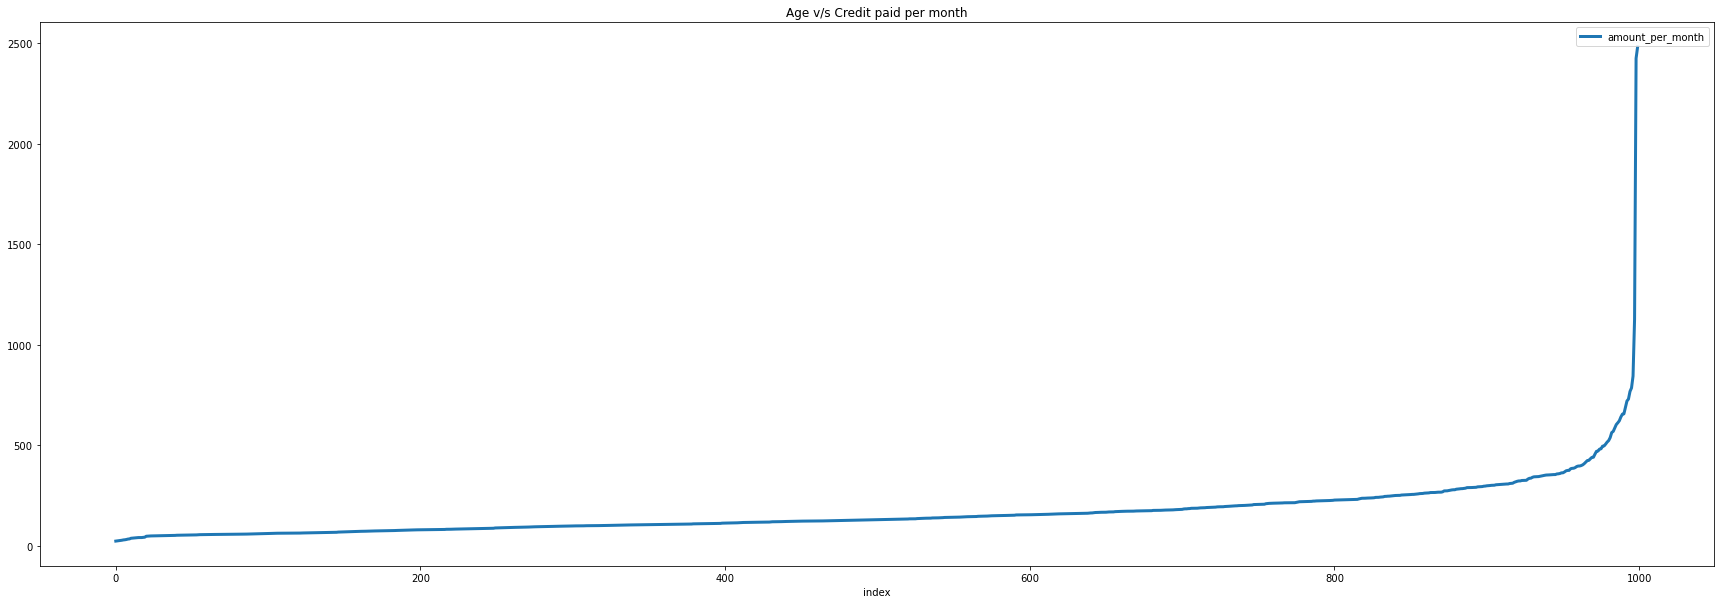

In [14]:
'''ax = plt.gca()
rslt_df = df.sort_values(by = 'amount_per_month').reset_index(drop=True)
rslt_df['index'] = rslt_df.index
rslt_df.plot(kind='line',x='index',y='amount_per_month',ax=ax,title='Age v/s Credit paid per month',figsize=(30,10),lw=3)
plt.show()'''